In [42]:
import requests
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import shapes
from rasterio.transform import *
from rasterio.plot import show
from rasterio.mask import geometry_mask, mask
from rasterio.warp import reproject
from shapely.geometry import mapping, shape, Polygon, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import timedelta
from xml.dom import minidom
from scipy.ndimage import zoom
from skimage import img_as_ubyte
from skimage.exposure import equalize_adapthist as _hist
import seaborn as sns
import gc
from pyproj import Proj, transform
from functools import partial
from shapely.geometry import mapping

import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (27, 9)
plt.rcParams['font.size'] = 12

# ASO U-net Prep

There are several goals here, in service of the eventual goal of using a u-net neural architecture to learn snow/no-snow maps from ASO snow observations and Planet Labs imagery. 

1. Align ASO Rasters to a Planet image
2. Create files: the image, and the snow map. 
3. Tile both the image and snow map into (512,512) in order to feed u-net architecture. 

In [2]:
YEAR = 2017
asodb = "../data/aso-urls.csv"

asourls = pd.read_csv(asodb, parse_dates=[0]).set_index('date')
asourls = asourls[asourls.index.year == YEAR]
display(asourls)
image = asourls.iloc[1]
asoImage = rio.open(image.url)
image_crs = ccrs.epsg(asoImage.crs['init'].split(":")[1])


,url
date,
2017-03-03,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2017-04-01,https://aso.jpl.nasa.gov/_include/new_geotiff/...


In [3]:
print(image)

url    https://aso.jpl.nasa.gov/_include/new_geotiff/...
Name: 2017-04-01 00:00:00, dtype: object


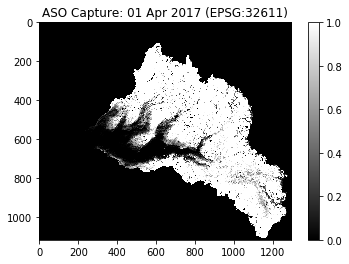

In [4]:
plt.imshow(asoImage.read(1).astype('float32'), cmap="binary_r", vmax=1, vmin=0)
plt.title("ASO Capture: {:%d %b %Y} (EPSG:{})".format(image.name, image_crs.epsg_code))
plt.colorbar()


In [5]:
transform(Proj(asoImage.crs), Proj('+init=epsg:3857'), 620.0, 112.0)

(-13523446.771245625, 112.4524812126176)

In [6]:

geoms = [shape(s[0]) for s in rio.features.shapes((asoImage.read(1).astype('float32') > 0.95).astype('int16'), transform=asoImage.transform) if s[1] == 1]
geoms = gpd.GeoDataFrame(geometry=geoms)
geoms.geometry = geoms.geometry.buffer(0) # self-intersection issues
geoms.crs = asoImage.crs
geoms['id'] = geoms.index
geoms['area'] = geoms.geometry.area
geoms = geoms.sort_values('area', ascending=False)
geoms = geoms.to_crs(ccrs.PlateCarree().proj4_init)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [47]:
geoms.sort_values('area', ascending=False).iloc[5:10].to_json()

'{"type": "FeatureCollection", "features": [{"id": "2122", "type": "Feature", "properties": {"id": 2122, "area": 315001.27372276754}, "geometry": {"type": "Polygon", "coordinates": [[[-119.20835718396171, 37.83447615687221], [-119.20778938716121, 37.834486807206574], [-119.20776253393218, 37.83358616069146], [-119.20719474372497, 37.8335968079477], [-119.20716789858444, 37.832696160934965], [-119.20660011497031, 37.83270680511326], [-119.20657327791766, 37.83180615760302], [-119.20600550089644, 37.83181679870353], [-119.20595184416078, 37.83001550253392], [-119.20651960739924, 37.83000486211964], [-119.20708737033883, 37.829994218970945], [-119.20706052998207, 37.829093571341005], [-119.20762828573181, 37.82908292580121], [-119.20819604118252, 37.82907227752713], [-119.20818261456195, 37.82862195399761], [-119.2087503662682, 37.828611303160976], [-119.20931811767532, 37.82860064959009], [-119.20929125155067, 37.82770000310228], [-119.20985899576817, 37.82768934714078], [-119.2109944833

In [43]:
mapping(a)

{'coordinates': (((-119.22232226929565, 37.82655358554206),
   (-119.22118680754441, 37.82657501434001),
   (-119.22110578591624, 37.82387309518922),
   (-119.22053807525681, 37.82388380445122),
   (-119.22052457614923, 37.8234334842849),
   (-119.22109228336433, 37.823422775195574),
   (-119.22107878111322, 37.82297245516331),
   (-119.22164648458332, 37.82296174351305),
   (-119.22165999027867, 37.8234120633726),
   (-119.22222769689212, 37.823401348815985),
   (-119.2222412063326, 37.82385166846417),
   (-119.2228089160894, 37.8238409510011),
   (-119.22284945654992, 37.82519190919547),
   (-119.22228173645978, 37.82520262717694),
   (-119.22232226929565, 37.82655358554206)),),
 'type': 'Polygon'}

In [48]:
with open(os.path.basename(image.url).split(".")[0] + "_0.95_5-10.geojson", 'w') as outfile:
    outfile.write(geoms.sort_values('area', ascending=False).iloc[5:10].to_json())

In [5]:
!ls ../images/ASO/

0_20160620_191028_0c79_cropped.pkl  0_20170401_175413_1024_cropped.pkl
0_20160620_191028_0c79_cropped.png  0_20170401_175413_1024_cropped.tif
0_20160620_191028_0c79_hist.png     0_20170401_175413_1024_hist.png
0_20160620_191028_0c79.tif	    0_20170401_175413_1024.tif
0_20160620_191028_0c79.xml	    0_20170401_175413_1024.xml
0_20170306_175941_0e19.tif	    0_20170404_175436_1019.tif
0_20170306_175941_0e19.xml	    0_20170404_175436_1019.xml
0_20170306_175941_0e19.zip	    0_20170404_180056_0e19.tif
0_20170401_175413_1024-Copy1.tif    0_20170404_180056_0e19.xml
0_20170401_175413_1024_cropped.csv  scale_and_tile.py


In [10]:
satimage = rio.open("../images/ASO/0_20170401_175413_1024.tif")

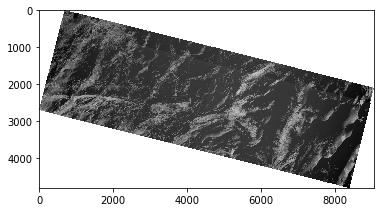

In [11]:
plt.imshow(satimage.read(4), cmap='binary')

In [12]:
bl = (satimage.bounds.left, satimage.bounds.bottom)
tl = (satimage.bounds.left, satimage.bounds.top)
br = (satimage.bounds.right, satimage.bounds.bottom)
tr = (satimage.bounds.right, satimage.bounds.top)
bounds = Polygon([bl, tl, tr, br])

maskedaso, maskedtransform = mask(asoImage, [mapping(bounds)])


In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(asoImage.read(1).astype('float32'), cmap='binary', transform=ccrs.epsg('32611'))
#plt.imshow(maskedaso.data.squeeze(), alpha=0.6)


In [ ]:
satimage.shape


In [53]:
maskedaso.squeeze().shape

(1119, 1297)

In [29]:
out = zoom(maskedaso.squeeze(), 16.61)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [30]:
out.shape

(4734, 9052)

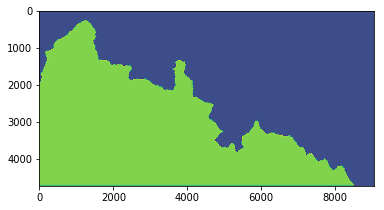

In [31]:
show(out)

In [8]:
out

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-9bc27bdc8279>", line 1, in <module>
    out
NameError: name 'out' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1090, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_

NameError: name 'out' is not defined